# Notebook to train a SVM car/no-car classifier 

### Preparing and visualizing the data for feature extraction

vehicles 8792
non-vehicles 9040


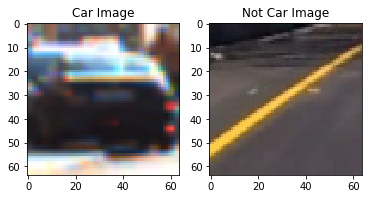

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn import svm
from sklearn.svm import SVR
import pickle
%matplotlib inline
# Read in our vehicles
l1 = glob.glob('vehicles/**/*.png',recursive=True)
l2 = glob.glob('non-vehicles/**/*.png',recursive=True)  
car_images=[]
no_car_images=[]
for image in l1:
    car_images.append(image)
for image in l2:
    no_car_images.append(image)

print('vehicles',len(car_images))
print('non-vehicles',len(no_car_images))
# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element

# Generate a random index to look at a car image
indx_car = np.random.randint(0, len(car_images))
indx_no_car = np.random.randint(0, len(no_car_images))
# Read in the image
image_car = mpimg.imread(car_images[indx_car])
image_not_car = mpimg.imread(no_car_images[indx_no_car])

# Plot the examples
fig = plt.figure(0)
plt.subplot(121)
plt.imshow(image_car, cmap='gray')
plt.title('Car Image')
plt.subplot(122)
plt.imshow(image_not_car, cmap='gray')
plt.title('Not Car Image')
plt.show()


### Class definition for classifier settings

In [2]:
class classifier:
    def __init__(self,inpCol='RGB', featCol = 'HSV', orient = 9, pixPerCell = 8, cellPerBlock=2, 
                 spatialSize=16, histBin = 32, hogChannels='ALL',folder_car='.',folder_not_car='.', 
                 modelFilename = 'model001.pkl'):
        self.input_color_space = inpCol
        self.feature_color_space = featCol
        self.num_orient = orient
        self.pix_per_cell = pixPerCell
        self.cell_per_block = cellPerBlock
        self.spatial_size = spatialSize
        self.num_histbin = histBin
        self.hog_channels = hogChannels
        self.model_filename = modelFilename
        files_car = glob.glob(folder_car,recursive=True)
        self.file_list_car = []
        files_not_car = glob.glob(folder_not_car,recursive=True)
        self.file_list_not_car = []
        for imageN in files_car:
            self.file_list_car.append(imageN)
        for imageN in files_not_car:
            self.file_list_not_car.append(imageN)
        
    # Define a function to compute color histogram features  
    def color_hist(self, img, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=self.num_histbin, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=self.num_histbin, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=self.num_histbin, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

    # Define a function to compute binned color features  
    def bin_spatial_feat(self,img):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, (self.spatial_size,self.spatial_size)).ravel() 
        # Return the feature vector
        return features

    def extract_features(self,list_imgs = []):

        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in list_imgs:
            # Read in each one by one
            image = mpimg.imread(file)
            # apply color conversion if other than 'RGB'
            if self.feature_color_space != 'RGB':
                if self.feature_color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif self.feature_color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif self.feature_color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif self.feature_color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif self.feature_color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)   
                else: feature_image = np.copy(image)    
            else:
                feature_image = np.copy(image)

            # Apply bin_spatial() to get spatial color features
            spatial_features = self.bin_spatial_feat(feature_image)
            # Apply color_hist() also with a color space option now
            hist_features = self.color_hist(feature_image)

            # Get Hog Features
            hog_features = []
            # Call get_hog_features() with vis=False, feature_vec=True
            if self.hog_channels == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(self.get_hog_features(feature_image[:,:,channel], 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel],vis=False, feature_vec=True)

            # Append the new feature vector to the features list
            features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        # Return list of feature vectors
        return features

    # Define a function to return HOG features and visualization
    def get_hog_features(self, img,   
                            vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=self.num_orient, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                      cells_per_block=(self.cell_per_block, self.cell_per_block), block_norm= 'L2-Hys',
                                      transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=self.num_orient, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                           cells_per_block=(self.cell_per_block, self.cell_per_block), block_norm= 'L2-Hys',
                           transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features
        
    #Train the classifier
    def train(self):

        #extract the features
        car_features = self.extract_features(self.file_list_car)
        notcar_features = self.extract_features(self.file_list_not_car)
        
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=rand_state)

        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X_train)
        # Apply the scaler to X
        X_train = X_scaler.transform(X_train)
        X_test = X_scaler.transform(X_test)

        print('Feature vector length:', len(X_train[0]))

        # Use a non-linear svm with 'rbf' kernel
        svc = svm.SVC()# probability=True)
        svc.fit(X_train, y_train)

        pickle.dump((svc,self,X_scaler),open(self.model_filename,'wb'))
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

        n_predict = 10

        print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        
        return svc,X_scaler
    
    def get_scalar(self):
        #extract the features
        car_features = self.extract_features(self.file_list_car)
        notcar_features = self.extract_features(self.file_list_not_car)
        
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=rand_state)

        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X_train)
        
        return X_scaler

### Function to train the classifier

In [1]:
def get_model_for_classifier(inp_fol_car,inp_fol_not_car,model_filename=None,attached_information=True):
    if model_filename != None and attached_information == False:
        classiFier = classifier(inpCol='RGB', featCol = 'HSV', orient = 15, pixPerCell = 16, cellPerBlock=2,
                                spatialSize=16, histBin = 32, hogChannels='ALL',folder_car=inp_fol_car,folder_not_car=inp_fol_not_car,
                                modelFilename = 'model001.pkl')
        scale_data = classiFier.get_scalar()
        svc = pickle.load(open(model_filename,rb))
        return svc,classiFier,scale_data
    
    elif model_filename != None and attached_information == True:
        svc,classiFier,X_scaler = pickle.load(open(model_filename,rb))
        return svc,classiFier,X_scaler
    else:
        classiFier = classifier(inpCol='RGB', featCol = 'HSV', orient = 15, pixPerCell = 16, cellPerBlock=2,
                                spatialSize=16, histBin = 32, hogChannels='ALL',folder_car=inp_fol_car,folder_not_car=inp_fol_not_car,
                                modelFilename = 'model001.pkl')
        svc,X_scaler = classiFier.train()
        return svc,classiFier,X_scaler 


### Lets try training the model


In [4]:
svc,classiFier,X_scaler = get_model_for_classifier('vehicles/**/*.png','non-vehicles/**/*.png')

Feature vector length: 2484
Test Accuracy of SVC =  0.9933
My SVC predicts:  [0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
For these 10 labels:  [0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
